# Data Science Recap

  * https://www.dataquest.io/blog/web-scraping-beautifulsoup/

## Web Scraping with BeautifulSoup - IMDB and Metacritic

  * **Requests**
  * **Beautiful Soup**
  * **Pandas**
  * **Matplotlib**

<img src = "IMDB.png" width = 500 align = 'left'>

<hr>

## Survey webpage data structure

https://www.imdb.com/search/title/?release_date=2017-01-01,2017-12-31&sort=num_votes,desc


<img src = "IMDB F12.png" width = 800 align = 'left'>

### IMDB 2017 releases - most voted

http://www.imdb.com/search/title?release_date=2017&sort=num_votes,desc&page=1

### Prepare python packages

In [1]:
pip install BeautifulSoup4 requests

     |████████████████████████████████| 102kB 17.8MB/s ta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Retrieve first page data

headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 6.3; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/54.0.2840.71 Safari/537.36'} #header spoofing

url = 'http://www.imdb.com/search/title?release_date=2017&sort=num_votes,desc&page=1'

#connect to website

try:
    from requests import get
    response = get(url, headers=headers)
    print("Connection to ", url, "succesfull")
    print(response.text[:500]) # only first 500 char (from:to) - slice
except:
    print("An error occured.")

Connection to  http://www.imdb.com/search/title?release_date=2017&sort=num_votes,desc&page=1 succesfull



<!DOCTYPE html>
<html
    xmlns:og="http://ogp.me/ns#"
    xmlns:fb="http://www.facebook.com/2008/fbml">
    <head>
        
<script type='text/javascript'>var ue_t0=ue_t0||+new Date();</script>
<script type='text/javascript'>
window.ue_ihb = (window.ue_ihb || window.ueinit || 0) + 1;
if (window.ue_ihb === 1) {

var ue_csm = window,
    ue_hob = +new Date();
(function(d){var e=d.ue=d.ue||{},f=Date.now||function(){return+new Date};e.d=function(b){return f()-(b?0:d.ue_t0)};e.stub=function(b,a){


## Using BeautifulSoup to parse the HTML content

*parse out the div containers 'lister-item mode-advanced' (50) and 'lister-item-content'*

In [3]:
#parse page to BeautifulSoup using the internal HTML parser

from bs4 import BeautifulSoup
html_soup = BeautifulSoup(response.text, 'html.parser')
type(html_soup)


bs4.BeautifulSoup

In [4]:
# find_all movie containers 'lister-item moder-advanced' - 50 on one page

movie_containers = html_soup.find_all('div', class_ = 'lister-item mode-advanced')
print(len(movie_containers))

50


<hr>

### select and extract items of interest from the movie_containers

*lister-item-content*

  * The **name** of the movie.
  * The **year** of release.
  * The **IMDB** rating.
  * The **Metascore**.
  * The number of **votes**.

### Create the Script for multiple pages - bits and parts

In [6]:
# create lists to vary the page url. Changing the year and changing the page

pages = [str(i) for i in range(1,10)]
years_url = [str(i) for i in range(1990,2018)]

### Create the Script for multiple pages - puting it together

In [10]:
# Redeclaring the lists to store data in
names = []
years = []
imdb_ratings = []
metascores = []
votes = []

# Preparing the monitoring of the loop
from time import time
from IPython.core.display import clear_output
start_time = time()
requests = 0

# For every year in the interval 2000-2017
for year_url in years_url:

    # For every page in the interval 1-4
    for page in pages:

        # Make a get request
        response = get('http://www.imdb.com/search/title?release_date=' + year_url +
        '&sort=num_votes,desc&page=' + page, headers = headers)

        # Pause the loop
        sleep(randint(8,15))

        # Monitor the requests
        requests += 1
        elapsed_time = time() - start_time
        print('Request:{}; Frequency: {} requests/s'.format(requests, requests/elapsed_time))
        clear_output(wait = True)

        # Throw a warning for non-200 status codes
        if response.status_code != 200:
            warn('Request: {}; Status code: {}'.format(requests, response.status_code))

        # Break the loop if the number of requests is greater than expected
        '''
        if requests > 72:
            warn('Number of requests was greater than expected.')
            break
        '''

        # Parse the content of the request with BeautifulSoup
        page_html = BeautifulSoup(response.text, 'html.parser')

        # Select all the 50 movie containers from a single page
        mv_containers = page_html.find_all('div', class_ = 'lister-item mode-advanced')

        # For every movie of these 50
        for container in mv_containers:
            # If the movie has a Metascore, then:
            if container.find('div', class_ = 'ratings-metascore') is not None:

                # Scrape the name
                name = container.h3.a.text
                names.append(name)

                # Scrape the year
                year = container.h3.find('span', class_ = 'lister-item-year').text
                years.append(year)

                # Scrape the IMDB rating
                imdb = float(container.strong.text)
                imdb_ratings.append(imdb)

                # Scrape the Metascore
                m_score = container.find('span', class_ = 'metascore').text
                metascores.append(int(m_score))

                # Scrape the number of votes
                vote = container.find('span', attrs = {'name':'nv'})['data-value']
                votes.append(int(vote))

Request:252; Frequency: 0.07489634266581538 requests/s


In [12]:
import pandas as pd

movie_ratings = pd.DataFrame({'movie': names,
'year': years,
'imdb': imdb_ratings,
'metascore': metascores,
'votes': votes
})
print(movie_ratings.info())
movie_ratings.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11160 entries, 0 to 11159
Data columns (total 5 columns):
movie        11160 non-null object
year         11160 non-null object
imdb         11160 non-null float64
metascore    11160 non-null int64
votes        11160 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 436.1+ KB
None


,movie,year,imdb,metascore,votes
0,Goodfellas,(1990),8.7,89,922673
1,Edward Scissorhands,(1990),7.9,74,419545
2,Home Alone,(1990),7.6,63,411971
3,Back to the Future Part III,(1990),7.4,55,366612
4,The Godfather Part III,(1990),7.6,60,330619
5,Die Hard 2,(1990),7.2,67,316421
6,Total Recall,(1990),7.5,57,281424
7,Pretty Woman,(1990),7.0,51,264719
8,Dances with Wolves,(1990),8.0,72,223542
9,Ghost,(1990),7.0,52,181810


In [15]:
#movie_ratings.to_csv('movie_ratings2.csv')

In [16]:
movie_ratings = movie_ratings[['movie', 'year', 'imdb', 'metascore', 'votes']]
movie_ratings.head()

,movie,year,imdb,metascore,votes
0,Goodfellas,(1990),8.7,89,922673
1,Edward Scissorhands,(1990),7.9,74,419545
2,Home Alone,(1990),7.6,63,411971
3,Back to the Future Part III,(1990),7.4,55,366612
4,The Godfather Part III,(1990),7.6,60,330619


In [17]:
movie_ratings['year'].unique()

array(['(1990)', '(I) (1990)', '(1991)', '(1992)', '(1993)', '(1994)',
       '(1995)', '(I) (1995)', '(1996)', '(I) (1996)', '(1997)', '(1998)',
       '(I) (1998)', '(1999)', '(I) (1999)', '(2000)', '(I) (2000)',
       '(2001)', '(2002)', '(2003)', '(2004)', '(I) (2004)', '(2005)',
       '(I) (2005)', '(2006)', '(I) (2006)', '(2007)', '(I) (2007)',
       '(2008)', '(I) (2008)', '(2009)', '(I) (2009)', '(2010)',
       '(I) (2010)', '(2011)', '(I) (2011)', '(2012)', '(I) (2012)',
       '(2013)', '(I) (2013)', '(2014)', '(I) (2014)', '(II) (2014)',
       '(2015)', '(I) (2015)', '(II) (2015)', '(2016)', '(II) (2016)',
       '(I) (2016)', '(IX) (2016)', '(2017)', '(I) (2017)'], dtype=object)

In [18]:
movie_ratings.loc[:, 'year'] = movie_ratings['year'].str[-5:-1].astype(int)
movie_ratings['year'].head(3)

0    1990
1    1990
2    1990
Name: year, dtype: int64

In [19]:
movie_ratings.describe().loc[['min', 'max'], ['imdb', 'metascore']]

,imdb,metascore
min,3.7,16.0
max,9.3,100.0


In [20]:
movie_ratings['n_imdb'] = movie_ratings['imdb'] * 10
movie_ratings.head(3)

,movie,year,imdb,metascore,votes,n_imdb
0,Goodfellas,1990,8.7,89,922673,87.0
1,Edward Scissorhands,1990,7.9,74,419545,79.0
2,Home Alone,1990,7.6,63,411971,76.0


In [21]:
movie_ratings.to_csv('movie_ratings2.csv')

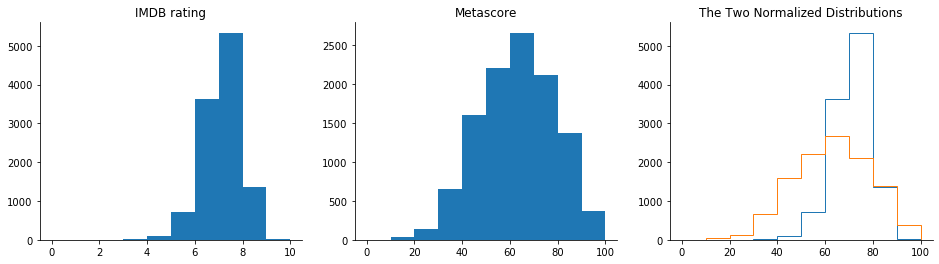

In [23]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (16,4))
ax1, ax2, ax3 = fig.axes
ax1.hist(movie_ratings['imdb'], bins = 10, range = (0,10)) # bin range = 1
ax1.set_title('IMDB rating')
ax2.hist(movie_ratings['metascore'], bins = 10, range = (0,100)) # bin range = 10
ax2.set_title('Metascore')
ax3.hist(movie_ratings['n_imdb'], bins = 10, range = (0,100), histtype = 'step')
ax3.hist(movie_ratings['metascore'], bins = 10, range = (0,100), histtype = 'step')
#ax3.legend(loc = 'upper left')
ax3.set_title('The Two Normalized Distributions')
for ax in fig.axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
plt.show()